# day03 A - Automatic Differentiation with JAX

In this notebook, we'll practice

* Part 0: Using **jax** for numpy-like array manipulation
* Part 1: Using **jax.grad** to compute gradients of univariate functions
* Part 2: Using **jax.grad** to compute gradients of multivariate functions of arrays
* Part 3: Using **jax.grad** to compute gradients of multivariate functions using PyTree data structs (dict, list, etc)

# Requirements

#### Run via your browser on a cloud CPU: No Install necessary!

Open [this notebook on Google Colab](#TODO)

#### Installing on your own laptop:

Follow Python environment setup instructions here:

https://www.cs.tufts.edu/comp/152BDL/2022f/setup_python_env.html

That step will install all the specific Python packages you'll need, which are listed in this conda environment:

https://www.cs.tufts.edu/comp/152BDL/2022f/notebooks/bdl_basic_env.yml

# Part 0: Brief intro to JAX 

It is safe to say that NumPy is the foundation of modern data science in Python

JAX is a recent Python library made available by researchers at Google

You can view JAX as a library that **expands NumPy** with two exciting features:

* Automatic differentiation (we'll use this A LOT in the BDL course)
* Huge Speed Acceleration via just-in-time compilation and [XLA](https://www.tensorflow.org/xla) (this may be useful in BDL)

As they say in the project tagline:

> JAX is NumPy on the CPU, GPU, and TPU, with great automatic differentiation for high-performance machine learning research.

There are already many great resources about JAX, including:

* the JAX docs: https://jax.readthedocs.io/en/latest/notebooks/quickstart.html
* the sourcecode itself: https://github.com/google/jax

This notebook (and later ones in this series) intend to be self-contained intros to the concepts you'll need to understand for our Bayesian Deep Learning course

In [1]:
# Import numpy for arrays
import numpy as np

# Import pandas for reading/writing tabular data
import pandas as pd

In [2]:
## Import JAX
import jax.numpy as jnp
import jax

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

## JAX's numpy wrapper (`jnp`) mostly behaves like numpy

## Examples: Manipulating scalars in JAX

In [4]:
jnp.square(.3)

DeviceArray(0.09, dtype=float32, weak_type=True)

In [5]:
jnp.cos(1.0)

DeviceArray(0.5403023, dtype=float32, weak_type=True)

In [6]:
jnp.exp(2.0)

DeviceArray(7.389056, dtype=float32, weak_type=True)

## Examples: Manipulating arrays in JAX

In [7]:
D = 3
a_DD = np.diag(np.asarray([1., 2., 3.]))
a_DD

array([[1., 0., 0.],
       [0., 2., 0.],
       [0., 0., 3.]])

In [8]:
b_D = np.asarray([5.0, 10.0, 20.])
b_D

array([ 5., 10., 20.])

In [9]:
jnp.asarray(b_D)

DeviceArray([ 5., 10., 20.], dtype=float32)

In [10]:
jnp.sum(b_D)

DeviceArray(35., dtype=float32)

### Matrix multiplication

In [11]:
jnp.dot(a_DD, b_D)

DeviceArray([ 5., 20., 60.], dtype=float32)

### Inverse of matrix in JAX

In [12]:
jnp.linalg.inv(a_DD)

DeviceArray([[1.        , 0.        , 0.        ],
             [0.        , 0.5       , 0.        ],
             [0.        , 0.        , 0.33333334]], dtype=float32)

## Gotcha 1:  Always provide array types, not lists of floats

In [13]:
b_D

array([ 5., 10., 20.])

In [14]:
# We CAN provide a NUMPY.NDARRAY of floats
jnp.sum(np.asarray(b_D))

DeviceArray(35., dtype=float32)

In [15]:
# We CAN provide a JAX.DeviceArray of floats
jnp.sum(jnp.asarray(b_D))

DeviceArray(35., dtype=float32)

In [16]:
# We CANNOT provide a list of floats
try:
    jnp.sum(list(b_D))
except TypeError as e:
    print("TypeError: " + str(e))

TypeError: sum requires ndarray or scalar arguments, got <class 'list'> at position 0.


# Part 1: Calling 'jax.grad' on univariate functions

Suppose we have a mathematical function of interest $f(x)$.

For example, let's consider $f(x) = cos(x^2)$

For now, we'll work with functions that have a scalar input and scalar output. 

We can of course ask: what is the derivative (aka *gradient*) of this function:

$$
g(x) \triangleq \frac{\partial}{\partial x} f(x)
$$

Instead of computing this gradient by hand via calculus/algebra, we can get the computer to do the hard work for us, using **automatic differentiation**.

### Idea 1.1: Implementing the function

To get started, we need to implement the math function $f(x)$ as a **Python function** `f`.

The Python function `f` needs to satisfy the following requirements:
* INPUT 'x': scalar float
* OUTPUT 'f(x)': scalar float
* All internal operations are composed of calls to functions from `jnp`, the `jax` version of `numpy`

**Important: USE jnp NOT np**
* You might be used to importing numpy as `import numpy as np`, and then using this shorthand for `np.cos(0.0)` or `np.square(5.0)` etc.
* For JAX to work, you need to instead use **jax's** provided numpy wrapper interface: `import jax.numpy as jnp`
* The `jnp` module has the same API as `np` for almost all everyday ops, so you can call `jnp.cos(0.0)`, `jnp.square(5.0)`, etc.



### Example 1.1: Square of x

In [17]:
def f_square(x):
    return jnp.square(x)

In [18]:
f_square(3.0)

DeviceArray(9., dtype=float32, weak_type=True)


### Idea 1.2: Computing the gradient via automatic differentiation

Now, if `f` meeds the above requirements, we can create a Python function `g` to compute derivatives of $f(x)$ by calling `autograd.grad`:

```
g = jax.grad(f)
```

The symbol `g` is now a **Python function** that takes the same input as `f`, but produces the derivative at a given input.


### Example 1.2: Gradient of x^2

In [19]:
g_square = jax.grad(f_square)

In [20]:
g_square(3.0)

DeviceArray(6., dtype=float32, weak_type=True)

In [21]:
g_square(0.0)

DeviceArray(0., dtype=float32, weak_type=True)

### Plot: Side-by-side f(x) and g(x)

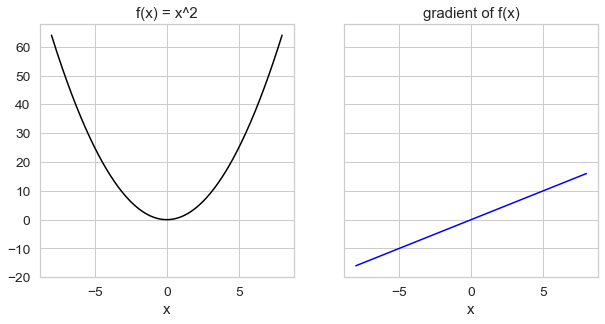

In [22]:
G = 300
x_grid_G = np.linspace(-8, 8, G)

fig_handle, subplot_grid = plt.subplots(
    nrows=1, ncols=2, figsize=(10,5), subplot_kw=dict(box_aspect=1),
    sharex=True, sharey=True, squeeze=False)
subplot_grid[0,0].plot(x_grid_G, [f_square(x_g) for x_g in x_grid_G], 'k-')
subplot_grid[0,0].set_title('f(x) = x^2')
subplot_grid[0,0].set_xlabel('x')

subplot_grid[0,1].plot(x_grid_G, [g_square(x_g) for x_g in x_grid_G], 'b-')
subplot_grid[0,1].set_title('gradient of f(x)')
subplot_grid[0,1].set_xlabel('x');

## Exercise 1A: Define your own function and gradient

Consider the decaying periodic function: 

$$
f(x) = e^{-x/10} * cos(x)
$$

Can you compute its derivative using autograd and plot the result?


TIP: NumPy (and thus JAX) use the `.exp( )` and `.cos( )` functions to compute $e^x$ and $cos(x)$

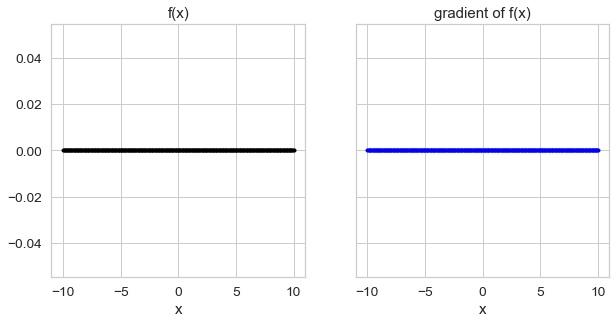

In [23]:
def f_decay(x):
    return 0.0 # TODO compute the decaying periodic function
    
g_decay = f_decay # TODO define g as gradient of f

# Plot the result
x_grid_G = np.linspace(-10, 10, G)
fig_h, subplot_grid = plt.subplots(
    nrows=1, ncols=2, figsize=(10,5), subplot_kw=dict(box_aspect=1),
    sharex=True, sharey=True, squeeze=False)
subplot_grid[0,0].plot(x_grid_G, [f_decay(x_g) for x_g in x_grid_G], 'k.-');
subplot_grid[0,0].set_title('f(x)');
subplot_grid[0,0].set_xlabel('x');

subplot_grid[0,1].plot(x_grid_G, [g_decay(x_g) for x_g in x_grid_G], 'b.-');
subplot_grid[0,1].set_title('gradient of f(x)');
subplot_grid[0,1].set_xlabel('x');

### Ideal Solution

You should get something like this:

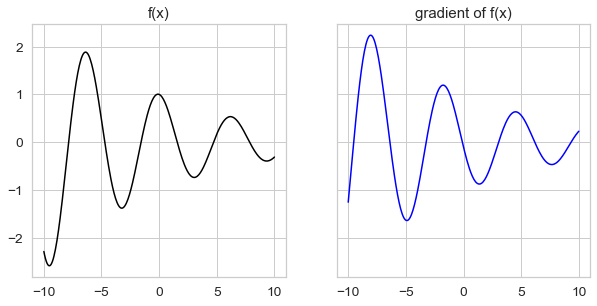

Note: As expected, the gradient crosses zero whenever the f function reaches a local min or max.

# Part 2: Using jax.grad on multivariate functions

Now, imagine the input $x$ could be a vector of size D. 

Our mathematical function $f(x)$ will map each input vector to a scalar.

We want the gradient function

\begin{align}
g(x) &\triangleq \nabla_x f(x)
\\
&= [
    \frac{\partial}{\partial x_1} f(x)
    \quad \frac{\partial}{\partial x_2} f(x)
    \quad \ldots \quad \frac{\partial}{\partial x_D} f(x)  ]
\end{align}

Instead of computing this gradient by hand via calculus/algebra, we can use autograd to do it for us.

### Idea 2.1: Implementing the function

First, we implement math function $f(x)$ as a **Python function** `f`.

Again, the key idea is that we call the `jnp` version of needed subprocedures *everywhere* inside the function

### Example 2.1: Compute the sum of squares

$$
f(x) = \sum_{d=1}^D x_d^2
$$

In [24]:
def f_sum_of_squares(x_D):
   return jnp.sum(jnp.square(x_D))

In [25]:
x_allzero_D = np.zeros(4)
print(x_allzero_D)

x_one_two_three_D = np.arange(3, dtype=np.float32)
print(x_one_two_three_D)

[0. 0. 0. 0.]
[0. 1. 2.]


In [26]:
f_sum_of_squares(x_allzero_D)

DeviceArray(0., dtype=float32)

In [27]:
f_sum_of_squares(x_one_two_three_D)

DeviceArray(5., dtype=float32)

### Idea 2.2: Call jax.grad to compute gradient

In [28]:
g_sum_of_squares = jax.grad(f_sum_of_squares)

In [29]:
g_sum_of_squares(x_allzero_D)

DeviceArray([0., 0., 0., 0.], dtype=float32)

In [30]:
g_sum_of_squares(x_one_two_three_D)

DeviceArray([0., 2., 4.], dtype=float32)

# Part 3: Using jax.grad for functions of pytrees (lists, dicts, tuples)

One of the best features of JAX is that it can naturally handle all your favorite Python data structures (like lists or dicts or tuples).

This can help us when it is natural to define models as structured compositions of simpler parts (e.g. the layers of a neural net). We don't need to turn our model into one giant flat array of all weights and biases. We can express things more naturally.

JAX supports a generic kind of object they call a "pytree", which is really any kind of nested container where the constituent elements are either:

* a numeric data type that supports differentiation (e.g. a float or an array of floats)
* any container types (lists, tuples, dicts, namedtuple, None, OrderedDict)

All the classic python data structures like `list`, or `dict` or `tuple` are subsumed as pytrees

Nicely, any heterogeneous composition of structures (like a list of dicts or a dict with tuple values) is also a pytree.

For Official Docs, see here:
https://jax.readthedocs.io/en/latest/jax-101/05.1-pytrees.html

### Idea 3.0: JAX pytrees

Here's a simple utility method that will pretty-print any PyTree object

Essentially, will do a depth-first traversal of the tree, 
printing each internal node and each leaf as one line.

In [31]:
def pretty_print_pytree(pytree, depth=0, all_leaves=None):
    ''' Pretty print PyTree
    
    Post Condition
    --------------
    Each internal node is printed as one line, indicating its type
    Each leaf element is printed out as one line, indicating its type and its shape
    We cast 0-dim arrays to 1-dim so the shapes make sense.
    
    Returns
    -------
    None. Prints to stdout.
    '''
    offset = "  " * depth # indent by two spaces for every lower level of the tree
    offset_child = offset + "  "
    print(offset + "TREE type %s" % (str(type(pytree))))
    rootdef = jax.tree_util.tree_structure(pytree)
    if all_leaves is None:
        all_leaves = jax.tree_util.tree_leaves(pytree)
    
    for childdef in jax.tree_util.treedef_children(rootdef):
        child = jax.tree_util.tree_unflatten(childdef, np.zeros(childdef.num_leaves))
        if jax.tree_util.treedef_is_leaf(childdef):
            leaf_arr = np.atleast_1d(np.asarray(all_leaves.pop(0)))
            print(offset_child + "leaf type %s shape %s" % (
                str(type(child)), leaf_arr.shape))
        else:
            pretty_print_pytree(child, depth+1, all_leaves)
        

In [32]:
pretty_print_pytree([1.0, 2.0, [4.0, [11.11, 12.12], 6.0]])

TREE type <class 'list'>
  leaf type <class 'numpy.float64'> shape (1,)
  leaf type <class 'numpy.float64'> shape (1,)
  TREE type <class 'list'>
    leaf type <class 'numpy.float64'> shape (1,)
    TREE type <class 'list'>
      leaf type <class 'numpy.float64'> shape (1,)
      leaf type <class 'numpy.float64'> shape (1,)
    leaf type <class 'numpy.float64'> shape (1,)


In [33]:
pretty_print_pytree({
    'a':1.0,
    'b':np.arange(12).reshape((2,3,2)),
    'c':[0.0, np.asarray([3.,3.,3.]), (1.111, 2.222)]})

TREE type <class 'dict'>
  leaf type <class 'numpy.float64'> shape (1,)
  leaf type <class 'numpy.float64'> shape (2, 3, 2)
  TREE type <class 'list'>
    leaf type <class 'numpy.float64'> shape (1,)
    leaf type <class 'numpy.float64'> shape (3,)
    TREE type <class 'tuple'>
      leaf type <class 'numpy.float64'> shape (1,)
      leaf type <class 'numpy.float64'> shape (1,)


## Idea 3.1: Implementing a function of lists of arrays that is suitable for jax


The key ideas here are:

* It is fine to use normal Python control flow (if statements, for loops, etc)
* Make sure any array operations use `jnp`, not just plain old numpy

In [34]:
def f_sum_squares_given_list(list_of_arrays):
    ''' Compute the sum of squares of all arrays in a list
    
    Args
    ----
    list_of_arrays: a list of 1D arrays
        Each array can have any number of elements
    
    Returns
    -------
    f : scalar float
        The sum of squares over all elements of all arrays in provided list
    '''
    total = 0.0
    for arr in list_of_arrays:
        total += jnp.sum(jnp.square(arr))
    return total

## Idea 3.2: Call jax.grad to build the gradient-computing function

The syntax is the same as before:

```
        g = jax.grad(f)
```

The object we get back is again a Python function!

The return value of this function has the same nested type/shape as the original input!

In [35]:
g_sum_squares_given_list = jax.grad(f_sum_squares_given_list)

In [36]:
### Example with two entries

pytree2 = [
    np.asarray([1., 2., 3., 5.]),
    1.0 * np.zeros(5)]
print("INPUT LIST OF ARRAYS")
print(pytree2)


ans = g_sum_squares_given_list(pytree2)
print("GRADIENT OF SUM OF SQUARES")
print(ans)

INPUT LIST OF ARRAYS
[array([1., 2., 3., 5.]), array([0., 0., 0., 0., 0.])]
GRADIENT OF SUM OF SQUARES
[DeviceArray([ 2.,  4.,  6., 10.], dtype=float32), DeviceArray([0., 0., 0., 0., 0.], dtype=float32)]


In [37]:
### Example with 3 entries

pytree3 = [
    np.asarray([1.,2.,3.]),
    np.asarray([5., 7., 9., 11.]),
    np.asarray([1., 1.]),
    ]
print("INPUT LIST OF ARRAYS")
print(pytree3)


ans3 = g_sum_squares_given_list(pytree3)
print("GRADIENT OF SUM OF SQUARES")
print(ans3)

INPUT LIST OF ARRAYS
[array([1., 2., 3.]), array([ 5.,  7.,  9., 11.]), array([1., 1.])]
GRADIENT OF SUM OF SQUARES
[DeviceArray([2., 4., 6.], dtype=float32), DeviceArray([10., 14., 18., 22.], dtype=float32), DeviceArray([2., 2.], dtype=float32)]


## Idea 3.3: Element-wise operations on pytrees

Sometimes we want to:

* add something to each element of a pytree
* multiply each element by a value
* add together the corresponding elements of two pytrees

We can easily use JAX to do this!

JAX's `jax.tree_map` function makes it easy to perform such operations, as you'll see below.

### ADDITION utilities

In [38]:
def add_pytree_and_scalar(a_pytree, b):
    ''' Add the same scalar to each element of a pytree
    
    Args
    ----
    a_pytree : Pytree
    b        : float scalar

    Returns
    -------
    c_pytree : Pytree (could be a list,
        Will be same size as input tree
    '''
    return jax.tree_map(lambda a: a + b,
            a_pytree)

def add_pytrees(a_pytree, b_pytree):
    ''' Add two pytrees together
    
    Args
    ----
    a_pytree : Pytree
    b_pytree : Pytree, same shape as a_pytree
    
    Returns
    -------
    c_pytree : Pytree (list, dict, etc)
        Will be same size as input trees
    '''
    return jax.tree_map(lambda a,b: a+b,
            a_pytree, b_pytree,
        )

In [39]:
pytree3

[array([1., 2., 3.]), array([ 5.,  7.,  9., 11.]), array([1., 1.])]

In [40]:
add_pytree_and_scalar(pytree3, 3.)

[array([4., 5., 6.]), array([ 8., 10., 12., 14.]), array([4., 4.])]

### Subtraction utilities

In [41]:
def subtract_pytree_and_scalar(a_pytree, b):
    ''' Add the same scalar to each element of a pytree
    
    Args
    ----
    a_pytree : Pytree
    b        : float scalar

    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree - b
    '''
    return jax.tree_map(lambda a: a - b, a_pytree)

def subtract_pytrees(a_pytree, b_pytree):
    ''' Subtract one pytree from another
    
    Args
    ----
    a_pytree : Pytree
    b_pytree : Pytree, same shape as a_pytree
    
    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree - b_pytree
    '''
    return jax.tree_map(lambda a,b: a-b,
            a_pytree, b_pytree,
        )

In [42]:
subtract_pytrees(pytree3, pytree3)

[array([0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0.])]

### Multiplication utilities

In [43]:
def multiply_pytree_and_scalar(a_pytree, b):
    ''' Multiply the same scalar to each element of a pytree
    
    Args
    ----
    a_pytree : Pytree
    b        : float scalar

    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree * b
    '''
    return jax.tree_map(lambda a: a * b, a_pytree)

def eltwise_multiply_pytrees(a_pytree, b_pytree):
    ''' Multiply corresponding elts of two pytrees
    
    Args
    ----
    a_pytree : Pytree
    b_pytree : Pytree, same shape as a_pytree
    
    Returns
    -------
    c_pytree : Pytree, same shape as a_pytree
        Each elt will satisfy c_pytree = a_pytree * b_pytree
    '''
    return jax.tree_map(lambda a,b: a*b,
            a_pytree, b_pytree,
        )

In [44]:
pytree3

[array([1., 2., 3.]), array([ 5.,  7.,  9., 11.]), array([1., 1.])]

In [45]:
eltwise_multiply_pytrees(pytree3, pytree3)

[array([1., 4., 9.]), array([ 25.,  49.,  81., 121.]), array([1., 1.])]